In [9]:
# once i have wholegenome_offset.trees
import pandas as pd
import tskit
import allel
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tsinfer
import pyslim
import json
import os
from collections import defaultdict

<AxesSubplot:ylabel='Count'>

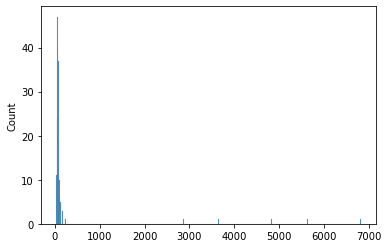

In [63]:
sns.histplot(het_ecotypes)

/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

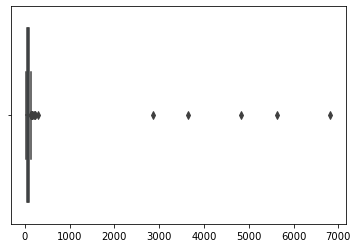

In [67]:
sns.boxplot(het_ecotypes)

/carnegie/binaries/centos7/conda/3.7/envs/python_3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

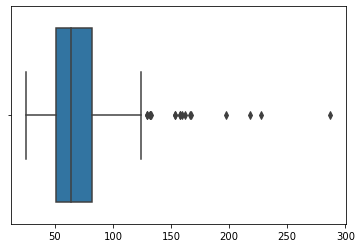

In [70]:
sns.boxplot(het_ecotypes[het_ecotypes < 1000])

In [65]:
per_het_per_ecotype = (het_ecotypes / 3235480) * 100

<AxesSubplot:ylabel='Count'>

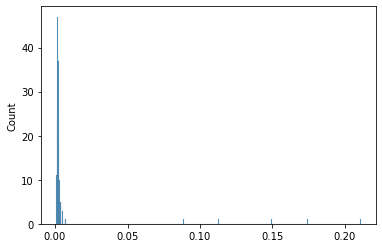

In [66]:
sns.histplot(per_het_per_ecotype)
#per_het_per_ecotype

In [55]:
het_sites = geno.count_het(axis=1)

In [58]:
## heterozigous sites
pd.Series(het_sites).value_counts()

0    3200006
1      31539
2       3180
3        661
4         94
dtype: int64

based on my hipothesis, then if i only calculate the alt allele count, that would solve a lot of the variation coming from selfing/heterozigous combination 

In [111]:
def generate_nonhet_pos():
    vcf = allel.read_vcf('../treeseq/wholegenome_offset.vcf')
    ## extract the genotype from the vcf file
    geno = vcf["calldata/GT"]
    ## calcualte the genotype counts
    geno = allel.GenotypeArray(vcf["calldata/GT"])
    het_sites = geno.count_het(axis=1)
    mask_non_het_sites = het_sites==0 
    nonhet_pos = vcf['variants/POS'][mask_non_het_sites]
    pd.Series(nonhet_pos).to_csv('nonhet_pos_wholegenome_offset.csv')
    return

In [134]:
def filtering_pos (nonhet_pos, pos_new, geno_og, geno_new):
    pos_to_keep = np.intersect1d(nonhet_pos, pos_new)
    mask_pos_ogvcf = pd.Series(pos_og).isin(pos_to_keep)
    geno_og_rpos  = geno_og[mask_pos_ogvcf]
    mask_pos_newvcf = pd.Series(pos_new).isin(pos_to_keep)
    geno_new_rpos  = geno_new[mask_pos_newvcf]
    return geno_og_rpos, geno_new_rpos
    

In [118]:
def get_ecotype_geno_mapper(geno_og_rpos):
    geno_og_rpos = np.swapaxes(geno_og_rpos, 0, 1)
    ecotype_geno_mapper = {}
    for i,j in zip(geno_og_rpos, samples):
        geno = i.tobytes()
        ecotype_geno_mapper[geno] = j
    return ecotype_geno_mapper

In [119]:
from collections import defaultdict

In [120]:
def get_ecotype_counts(geno_new_rpos, pop_name):
    geno_new_rpos = np.swapaxes(geno_new_rpos, 0, 1)
    # Initialize a defaultdict to store the genotype counts
    ecotype_counts = defaultdict(int)
    # Count genotypes in geno_drift_resh
    for i in geno_new_rpos:
        sample = i.tobytes()
        ecotype = ecotype_geno_mapper.get(sample, 'other')
        ecotype_counts[ecotype] += 1
    name = 'count'+ pop_name
    ecotype_countsdf = pd.DataFrame(list(ecotype_counts.items()), columns=['ecotype', name])
    ecotype_countsdf['ecotype'] = ecotype_countsdf['ecotype'].str.split('_').str[0]
    return ecotype_countsdf
    

In [115]:
nonhet_pos = np.array(pd.read_csv('nonhet_pos_wholegenome_offset.csv',usecols=[1])['0'])

In [122]:
vcf_og = allel.read_vcf('../treeseq/wholegenome_offset.vcf', fields=['calldata/GT', 'variants/POS', 'samples'])
geno_og = vcf_og['calldata/GT']
pos_og = vcf_og['variants/POS']
samples = vcf_og['samples']

In [137]:
vcf_drift = allel.read_vcf(f'result_drift1.vcf', fields=['variants/POS', "calldata/GT"])
pos_vcf_drift = vcf_drift['variants/POS']
geno_drift = vcf_drift["calldata/GT"]

geno_og_rpos, geno_new_rpos = filtering_pos (nonhet_pos, pos_vcf_drift, geno_og, geno_drift)

ecotype_geno_mapper = get_ecotype_geno_mapper(geno_og_rpos)

ecotype_countsdf = get_ecotype_counts(geno_new_rpos, 'drift')

In [138]:
ecotype_countsdf

,ecotype,countdrift
0,6911,6
1,9512,3
2,other,57
3,7003,10
4,9775,8
...,...,...
176,6209,1
177,9544,1
178,9547,3
179,9941,2


In [2]:
def generate_nonhet_pos():
    vcf = allel.read_vcf('../treeseq/wholegenome_offset.vcf')
    ## extract the genotype from the vcf file
    geno = vcf["calldata/GT"]
    ## calcualte the genotype counts
    geno = allel.GenotypeArray(vcf["calldata/GT"])
    het_sites = geno.count_het(axis=1)
    mask_non_het_sites = het_sites==0 
    nonhet_pos = vcf['variants/POS'][mask_non_het_sites]
    pd.Series(nonhet_pos).to_csv('nonhet_pos_wholegenome_offset.csv')
    return

def filtering_pos (nonhet_pos, pos_new, geno_og, geno_new):
    pos_to_keep = np.intersect1d(nonhet_pos, pos_new)
    mask_pos_ogvcf = pd.Series(pos_og).isin(pos_to_keep)
    geno_og_rpos  = geno_og[mask_pos_ogvcf]
    mask_pos_newvcf = pd.Series(pos_new).isin(pos_to_keep)
    geno_new_rpos  = geno_new[mask_pos_newvcf]
    return geno_og_rpos, geno_new_rpos
    

def get_ecotype_geno_mapper(geno_og_rpos):
    geno_og_rpos = np.swapaxes(geno_og_rpos, 0, 1)
    ecotype_geno_mapper = {}
    for i,j in zip(geno_og_rpos, samples):
        geno = i.tobytes()
        ecotype_geno_mapper[geno] = j
    return ecotype_geno_mapper

def get_ecotype_counts(geno_new_rpos, pop_name):
    geno_new_rpos = np.swapaxes(geno_new_rpos, 0, 1)
    # Initialize a defaultdict to store the genotype counts
    ecotype_counts = defaultdict(int)
    # Count genotypes in geno_drift_resh
    for i in geno_new_rpos:
        sample = i.tobytes()
        ecotype = ecotype_geno_mapper.get(sample, 'other')
        ecotype_counts[ecotype] += 1
    name = 'count'+ pop_name
    ecotype_countsdf = pd.DataFrame(list(ecotype_counts.items()), columns=['ecotype', name])
    ecotype_countsdf['ecotype'] = ecotype_countsdf['ecotype'].str.split('_').str[0]
    return ecotype_countsdf

In [3]:
nonhet_pos = np.array(pd.read_csv('nonhet_pos_wholegenome_offset.csv',usecols=[1])['0'])

In [4]:
vcf_og = allel.read_vcf('../treeseq/wholegenome_offset.vcf', fields=['calldata/GT', 'variants/POS', 'samples'])
geno_og = vcf_og['calldata/GT']
pos_og = vcf_og['variants/POS']
samples = vcf_og['samples']

In [5]:
variances = pd.read_csv('variances.txt',header=None)[0]
optimas = pd.read_csv('optimas.txt',header=None)[0]

In [16]:
ecotypes_grenenet = pd.read_csv('ecotypes_grenenet.txt',header=None, dtype=object)
ecotypes_grenenet.columns= ['ecotype']
ecotypes_grenenet = pd.concat([ecotypes_grenenet, pd.DataFrame(data = {'ecotype': ['other']}, index=[231])],axis=0)

In [27]:
for i in variances:
    for j in optimas:
        vcf_filename = f'result_selection_var{i}_optima{j}.vcf'
        # Check if the VCF file exists and is not empty (all individuals died)
        if os.path.exists(vcf_filename) and os.path.getsize(vcf_filename) > 0:
        
            ## import each of teh vcf realted to the drift simulation
            vcf_new = allel.read_vcf(vcf_filename, fields = ['calldata/GT', 'variants/POS'])
            ##extract the posisions and the geno array
            pos_new = vcf_new['variants/POS']
            geno_new = vcf_new['calldata/GT']
            ## for each of them create the ecotype geno mapper, depending on the positions that made it 
            geno_og_rpos, geno_new_rpos = filtering_pos (nonhet_pos, pos_new, geno_og, geno_new)
            ecotype_geno_mapper = get_ecotype_geno_mapper(geno_og_rpos)
            ecotype_countsdf = get_ecotype_counts(geno_new_rpos, f'_selection_var{i}_optima{j}')
            ## merge with previous 
            ecotypes_grenenet = ecotypes_grenenet.merge(ecotype_countsdf, how='left', on ='ecotype')
        elif os.path.exists(vcf_filename) and os.path.getsize(vcf_filename) == 0:
            empty_col_name = f'counts_selection_var{i}_optima{j}'
            print('added empty column in ' + empty_col_name)
            ecotypes_grenenet[empty_col_name] = 0



OSError: [Errno 116] Stale file handle

In [13]:
ecotypes_grenenet['count_selection_var0.4344_optima0.2792'].sum()

900.0

In [20]:
ecotypes_grenenet.sum(axis=0)

ecotype                                    1000210006100111001310014159265515151655768577...
count_selection_var0.0869_optima0.0                                                    900.0
count_selection_var0.0869_optima0.2792                                                 746.0
count_selection_var0.0869_optima0.5585                                                  78.0
count_selection_var0.0869_optima0.8377                                                  27.0
counts_selection_var0.0869_optima1.1169                                                    0
count_selection_var0.0869_optima1.3961                                                   3.0
count_selection_var0.0869_optima1.6754                                                  13.0
count_selection_var0.0869_optima1.9546                                                   6.0
count_selection_var0.0869_optima2.2338                                                   1.0
counts_selection_var0.0869_optima2.5131                               

In [21]:
ecotypes_grenenet

,ecotype,count_selection_var0.0869_optima0.0,count_selection_var0.0869_optima0.2792,count_selection_var0.0869_optima0.5585,count_selection_var0.0869_optima0.8377,counts_selection_var0.0869_optima1.1169,count_selection_var0.0869_optima1.3961,count_selection_var0.0869_optima1.6754,count_selection_var0.0869_optima1.9546,count_selection_var0.0869_optima2.2338,counts_selection_var0.0869_optima2.5131,counts_selection_var0.0869_optima2.7923,counts_selection_var0.0869_optima3.0715,counts_selection_var0.0869_optima3.3507,counts_selection_var0.0869_optima3.63,counts_selection_var0.0869_optima3.9092
0,10002,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,10006,17.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,10011,9.0,12.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,10013,5.0,4.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,10014,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,6939,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
228,9940,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
229,9977,19.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0
230,9992,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [24]:
tskit.load('var0.0869_optima0.8377_result.trees')

In [ ]:
result_selection_var0.0869_optima2.2338.vcf

In [25]:
vcf_new = allel.read_vcf('result_selection_var0.0869_optima2.2338.vcf', fields = ['calldata/GT', 'variants/POS'])

In [26]:
vcf_new

{'calldata/GT': array([[[1, 1]],
 
        [[1, 1]],
 
        [[1, 1]],
 
        ...,
 
        [[1, 1]],
 
        [[1, 1]],
 
        [[1, 1]]], dtype=int8),
 'variants/POS': array([      419,       502,       508, ..., 119145662, 119145892,
        119145924], dtype=int32)}